<h3>Embedding Map Extraction</h3>

In [1]:
%%time
from PIL.Image import open
from numpy import array, float32, reshape, expand_dims, argmax
from numpy.random import rand
from watermarking import extraction, cnn, training
from os import listdir

Wall time: 5.2 s


In [2]:
import numpy as np

In [3]:
ground_truth = array(open("Watermark.tiff"), dtype=float32)

In [4]:
import matplotlib.pyplot as plt

## Convolution Testing

In [5]:
from watermarking import extraction, process, forward, cnn, attacks

In [100]:
image = open("static/training/grass0.tif")

In [101]:
ext = extraction.Extraction()

In [102]:
key = ext.extract_key_from_pil_image(image)

In [103]:
result = ext.get_embedding_map(process.Process.pil_to_open_cv(image), key)

In [104]:
array(result).max()

76.00000000000001

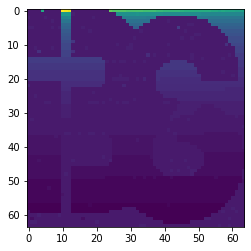

In [105]:
plt.imshow(result)

In [106]:
array(result)

array([[24., 24., 24., ..., 52., 52., 52.],
       [24., 24., 24., ..., 46., 46., 46.],
       [25., 24., 24., ..., 42., 42., 42.],
       ...,
       [24., 22., 24., ..., 24., 24., 24.],
       [24., 25., 25., ..., 24., 24., 24.],
       [24., 24., 24., ..., 24., 24., 24.]])

In [107]:
norm_image = []
for row in result:
    norm_row = []
    for _px in row:
        norm_row.append(float(round(_px)))
    norm_image.append(norm_row)
# norm_image2 = []
# for row in attacked:
#     norm_row = []
#     for _px in row:
#         norm_row.append(float(round(_px)))
#     norm_image2.append(norm_row)
# norm_image3 = []
# for row in attacked2:
#     norm_row = []
#     for _px in row:
#         norm_row.append(float(round(_px)))
#     norm_image3.append(norm_row)

In [108]:
f = forward.Forward(
    False,
    array([
        [norm_image]
    ]), # double array as batch and channel
    cnn.CNN.init_params()
)

initializing
(1, 1, 64, 64)


In [109]:
result = f.run()

encoder
shape:  (1, 1, 64, 64)
STACK: 0
conv per stack:  (1, 64, 64, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 64, 64, 4)
(1, 64, 64, 4)
norm:  (1, 4, 1, 1)  ssd  (1, 4, 1, 1)
ReLU and max pool
STACK: 1
conv per stack:  (1, 32, 32, 4)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change jus

In [110]:
array(result).shape

(64, 64)

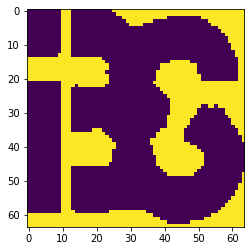

In [111]:
plt.imshow(result)

In [112]:
extraction.Extraction.normalized_correlation_coef(result, ground_truth)

0.9552496148988066

In [86]:
conved_images = []
for batch, image in enumerate([[norm_image]]):
    conved_images.append(
        f.conv_per_stack(
            array(image), f.ENCODER, 0, batch
        )
    )

conv per stack:  (1, 64, 64, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 64, 64, 4)
(1, 64, 64, 4)


In [ ]:
array(conved_images).shape

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(conved_images[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(conved_images[0][i], interpolation='nearest')

In [ ]:
conved_images = f.batch_norm_per_stack(
    conved_images,
    cnn.CNN.ENCODER,
    0
)

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(conved_images[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(conved_images[0][i], interpolation='nearest')

In [ ]:
processed_conv = []
for batch, image in enumerate(conved_images):
    # image = f.relu_per_stack(image, batch)
    image = f.max_pooling_per_stack(image, batch)
    processed_conv.append(image)

In [ ]:
processed_conv = array(processed_conv)

In [ ]:
processed_conv.shape

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(processed_conv[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(processed_conv[0][i], interpolation='nearest')

In [ ]:
conved_images = []
for batch, image in enumerate(processed_conv):
    conved_images.append(
        f.conv_per_stack(
            array(image), f.ENCODER, 1, batch
        )
    )

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(conved_images[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(conved_images[0][i], interpolation='nearest')

In [ ]:
conved_images = f.batch_norm_per_stack(
    conved_images,
    cnn.CNN.ENCODER,
    1
)

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(conved_images[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(conved_images[0][i], interpolation='nearest')

In [ ]:
processed = []
for batch, image in enumerate(processed_conv):
    image = f.upsample_per_stack(
        image, batch, 1
    )
    processed.append(image)

In [ ]:
fig = plt.figure(figsize=(50, 50))
for i in range(len(processed[0])):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(processed[0][i], interpolation='nearest')

In [ ]:
decoded = []
for batch, image in enumerate(processed):
    image = f.conv_per_stack(
        array(image), f.DECODER, 1, batch
    )
    decoded.append(image)

In [ ]:
plt.imshow(decoded[0][0])

In [ ]:
decoded = f.batch_norm_per_stack(
    decoded,
    cnn.CNN.DECODER,
    0
)

In [ ]:
plt.imshow(decoded[0][0])

In [ ]:
sm = f.softmax_per_batch(decoded)

In [ ]:
plt.imshow(sm)

<h1> Try to Predict All Data</h1>

In [113]:
train = training.Training()

initializing


In [114]:
def get_dataset(processing_path):
    images_filename = listdir(processing_path)
    attack_list = [2, 10, 36, 44]
    datasets = {}
    for i in attack_list:
        image = open(processing_path + "/" + images_filename[i])
        datasets[images_filename[i]] = train.normalize_embedding_maps(
            train.get_embedding_maps(                   
                train.apply_transformations(image),
                extraction.Extraction().extract_key_from_pil_image(image)
            )
        )
    return datasets

In [115]:
datasets = get_dataset(train.TRAINING_PATH)


total:  24
total:  24
total:  24
total:  24


In [116]:
params = cnn.CNN.init_params()

initializing


In [117]:
datasets.keys()

dict_keys(['baloons.tif', 'Corossion.tif', 'orange.tif', 'sofa.tif'])

In [118]:
results = []
for name, data in datasets.items():
    result = []
    for attacked in data:
        f = forward.Forward(
            False,
            [
                [attacked]
            ], # double array as batch and channel
            params
        )
        result.append(f.run())
    results.append(result)

as dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 32, 32, 8)
(1, 32, 32, 8)
norm:  (1, 8, 1, 1)  ssd  (1, 8, 1, 1)
(1, 8, 32, 32)
STACK: 0
ups and conv

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to 

In [144]:
for i in range(len(results[0])):
    print(
        preformat_NC(extraction.Extraction.normalized_correlation_coef(results[0][i], ground_truth)), ' & ',
        preformat_NC(extraction.Extraction.normalized_correlation_coef(results[1][i], ground_truth)), ' & ',
        preformat_NC(extraction.Extraction.normalized_correlation_coef(results[2][i], ground_truth)), ' & ',
        preformat_NC(extraction.Extraction.normalized_correlation_coef(results[3][i], ground_truth)), "\\\\"
    )

0.9207  &  0.8746  &  0.9511  &  0.9787 \\
0.9442  &  0.915  &  0.9481  &  0.9522 \\
0.9404  &  0.9432  &  0.943  &  0.9381 \\
0.9308  &  0.9326  &  0.9429  &  0.9378 \\
0.9325  &  0.9301  &  0.9437  &  0.9498 \\
0.9411  &  0.9404  &  0.9443  &  0.9388 \\
0.9414  &  0.9474  &  0.9423  &  0.9351 \\
0.946  &  0.9311  &  0.9375  &  0.9503 \\
0.9291  &  0.945  &  0.9444  &  0.9496 \\
0.9303  &  0.9404  &  0.9423  &  0.9375 \\
0.9222  &  0.9344  &  0.8931  &  0.9445 \\
0.910  &  0.9234  &  0.8987  &  0.9121 \\
0.9368  &  0.9417  &  0.9064  &  0.9391 \\
0.9324  &  0.9314  &  0.9496  &  0.9467 \\
0.9391  &  0.9373  &  0.9349  &  0.9482 \\
0.932  &  0.9436  &  0.9104  &  0.9356 \\
0.893  &  0.9319  &  0.929  &  0.9437 \\
0.9138  &  0.9424  &  0.9402  &  0.9473 \\
0.952  &  0.9614  &  0.9531  &  0.9738 \\
0.9602  &  0.9542  &  0.9311  &  0.9605 \\
0.9455  &  0.949  &  0.9034  &  0.9538 \\
0.9229  &  0.9239  &  0.9456  &  0.9755 \\
0.9433  &  0.9328  &  0.8728  &  0.953 \\
0.9339  &  0.9476  &  

In [143]:
def preformat_NC(value):
    if value > 1:
        return '1.0000'
    else:
        value = str(value)[:6]
        if value[-1] == '0':
            return value[:5]
        else:
            return value

In [138]:
array(results).shape

(4, 24, 64, 64)

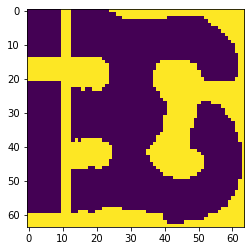

In [145]:
plt.imshow(results[2][10])

# Checking Convolution

In [ ]:
from watermarking import training

In [ ]:
%%time
train = training.Training()

In [ ]:
%%time
epoch = 1
losses = []
accs = []
for i in range(0, epoch):
    print('EPOCH: ', i)
    result, loss, acc, attacked_wm = train.auto_training()
    losses.append(loss)
    accs.append(acc)

train.store_params()

In [ ]:

ground_truth = array(ground_truth)
max_result = -1
chosen_img = None
for data in sm:
    background, foreground = data
    classified = []
    for i, row in enumerate(background):
        new_row = []
        for j, _px in enumerate(row):
            new_row.append(
                0 if _px > foreground[i][j] else 255
            )
        classified.append(new_row)
    classified = array(classified)
    a = ground_truth.ravel()
    b = classified.ravel()
    
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    
    if c.max() > max_result:
        max_result = c.max()
        chosen_img = classified
    print(c.max())

In [ ]:
plt.imshow(result[0][0])

In [ ]:
plt.imshow(cnn.CNN.softmax_classifier(result[0][0], result[0][1]))

In [ ]:
plt.imshow(chosen_img)

In [ ]:
print(len(result))
print(max_result)

In [ ]:
a = ground_truth.ravel()
b = array(result).ravel()

In [ ]:
a = (a - np.mean(a)) / (np.std(a) * len(a))
b = (b - np.mean(b)) / (np.std(b))
c = np.correlate(a, b, 'full')

In [ ]:
c.max()